# Tarea1: Grupo 5
# ResNet50

Mounted at /content/drive


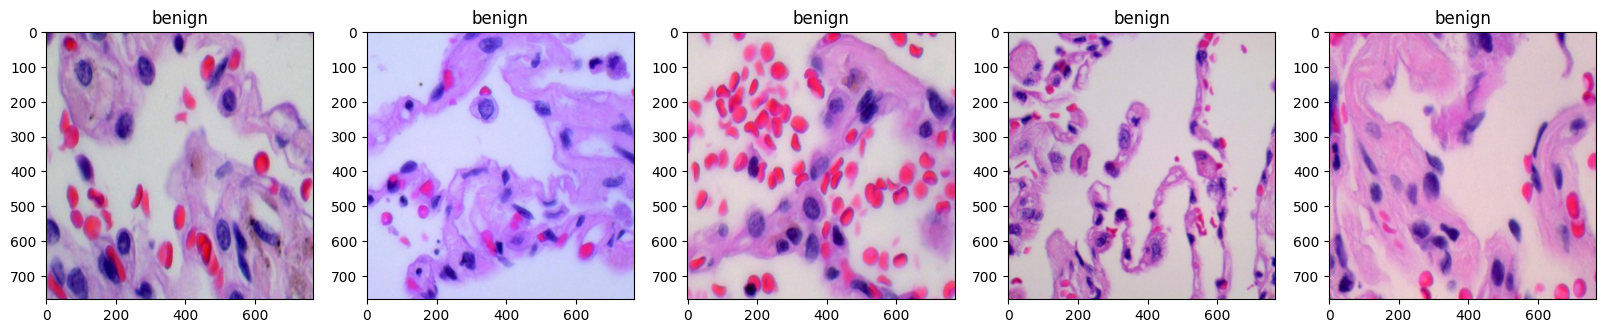

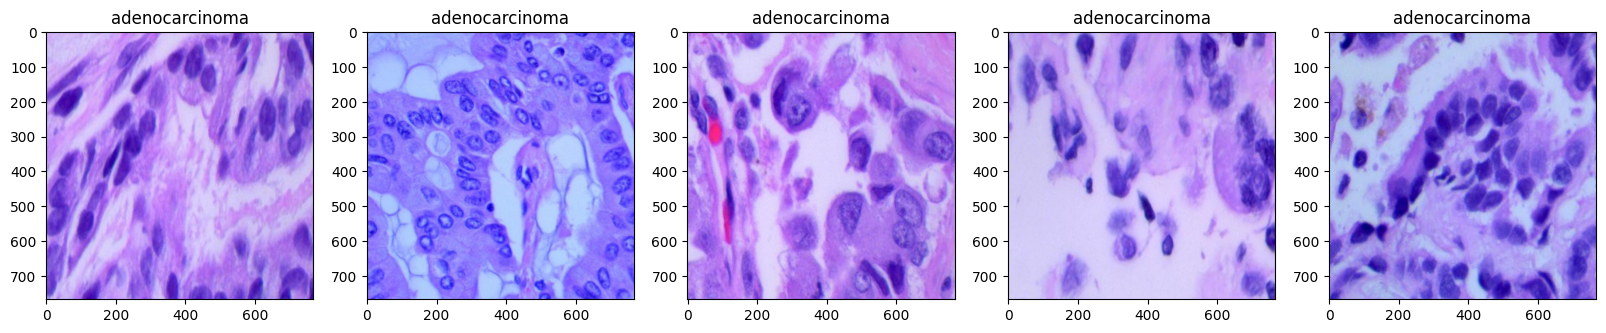

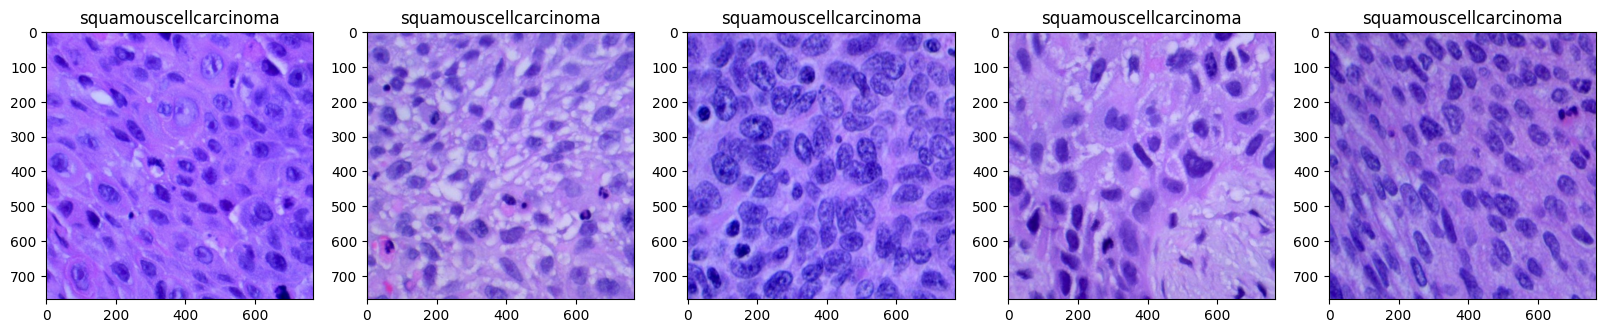

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
import matplotlib.pyplot as plt
import os

# Ruta en Google Drive donde están las imágenes
ruta_train = pathlib.Path("/content/drive/MyDrive/Dataset-2024/Lung_Cancer")

# Visualizar las imágenes
for clase in os.listdir(ruta_train):
    plt.figure(figsize=(20,10))
    path = os.path.join(ruta_train, clase)
    nombre_imagenes = os.listdir(path)

    # Mostramos 5 imágenes por clase
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        img = plt.imread(os.path.join(path, nombre_imagenes[i]))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.title(clase)
        plt.axis("on")

    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inicializa el generador de imágenes con la normalización y la división de validación
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25  # 25% para validación
)

# Carga los datos de entrenamiento
train_data = datagen.flow_from_directory(
    directory=ruta_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    subset='training'  # Especifica que este es el conjunto de entrenamiento
)

# Carga los datos de validación
validation_data = datagen.flow_from_directory(
    directory=ruta_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    subset='validation'  # Especifica que este es el conjunto de validación
)

Found 11250 images belonging to 3 classes.
Found 3750 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Cargar el modelo ResNet50 preentrenado en ImageNet sin la última capa
resnet = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# 2. Congelar las capas del modelo preentrenado para evitar que se ajusten
for layer in resnet.layers:
    layer.trainable = False

# 3. Añadir nuevas capas al modelo
x = resnet.output
x = GlobalAveragePooling2D()(x)  # Capa de Pooling Global
x = Dense(1024, activation='relu')(x)  # Capa totalmente conectada
predict = Dense(len(train_data.class_indices), activation='softmax')(x)  # Capa de salida con softmax

# 4. Crear el nuevo modelo
modelo_ResNet = Model(inputs=resnet.input,
                      outputs=predict)

# 5. Compilar el modelo
modelo_ResNet.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# 6. Mostrar el resumen del modelo
modelo_ResNet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
Early_Stop = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)

In [ ]:
history_ResNet = modelo_ResNet.fit(train_data,
        validation_data= validation_data,
        callbacks = [Early_Stop],
        epochs= 50
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 3717s 20s/step - accuracy: 0.4041 - loss: 1.0929 - val_accuracy: 0.5112 - val_loss: 1.0138
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 121s 669ms/step - accuracy: 0.5155 - loss: 1.0005 - val_accuracy: 0.5875 - val_loss: 0.9653
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 120s 663ms/step - accuracy: 0.5735 - loss: 0.9491 - val_accuracy: 0.5813 - val_loss: 0.9253
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 131s 723ms/step - accuracy: 0.6229 - loss: 0.9060 - val_accuracy: 0.6272 - val_loss: 0.8864
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 117s 646ms/step - accuracy: 0.6552 - loss: 0.8678 - val_accuracy: 0.7115 - val_loss: 0.8318
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 121s 665ms/step - accuracy: 0.6921 - loss: 0.8199 - val_accuracy: 0.7283 - val_loss: 0.7878
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 131s 725ms/step - accuracy: 0.7016 - loss: 0.7816 - val_accuracy: 0.7363 - val_loss: 0.7492
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 119s 656ms/step - accuracy: 0.7208 - loss: 0.739

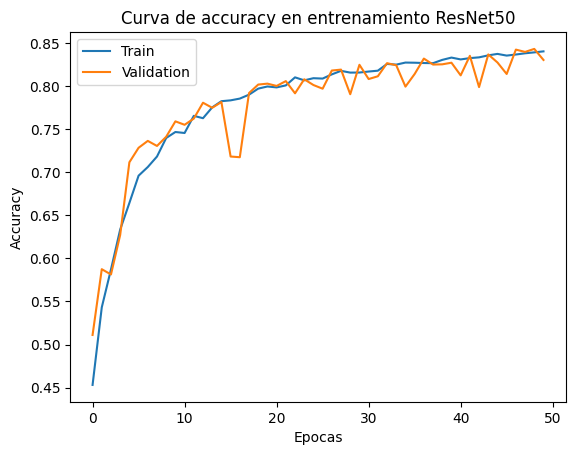

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_ResNet.history['accuracy'])
plt.plot(history_ResNet.history['val_accuracy'])
plt.title('Curva de accuracy en entrenamiento ResNet50')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

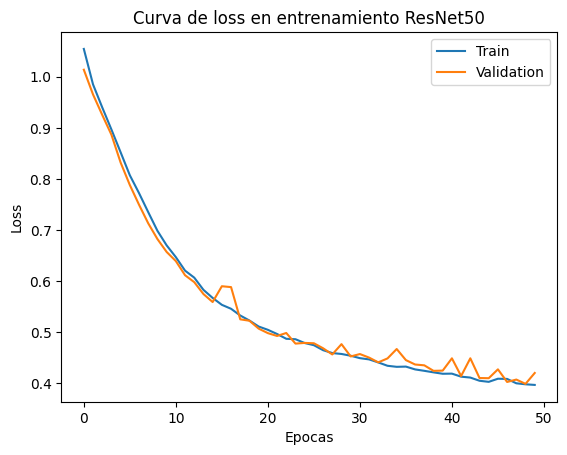

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_ResNet.history['loss'])
plt.plot(history_ResNet.history['val_loss'])
plt.title('Curva de loss en entrenamiento ResNet50')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
evaluation_ResNet = modelo_ResNet.evaluate(validation_data)
evaluation_ResNet

59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 630ms/step - accuracy: 0.8414 - loss: 0.4008


[0.3980594873428345, 0.8429333567619324]

In [ ]:
modelo_ResNet.save('ResNet50_Lung_Cancer.keras')

In [ ]:
import pickle
with open('history_ResNet.pkl', 'wb') as file_pi:
    pickle.dump(history_ResNet.history, file_pi)